In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot
%matplotlib inline

In [210]:
raw = pd.read_csv('groomed_train_users.csv')

In [211]:
raw = raw.drop(['Unnamed: 0'], axis=1)

In [212]:
raw.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,first_booking_made,target
0,0,34.0,1,0,5,2,4,6,2,3,8,0,7
1,2,38.0,1,0,5,7,8,6,2,3,8,0,7
2,1,56.0,0,3,5,2,4,6,2,6,21,1,10
3,1,42.0,1,0,5,2,4,6,2,3,17,1,11
4,0,41.0,0,0,5,2,4,6,2,3,8,1,10


In [213]:
raw['gender'].value_counts()

0    95688
1    63041
2    54440
3      282
Name: gender, dtype: int64

In [214]:
sessions1 = pd.read_csv("sessions.csv")
sessions2 = pd.read_csv("sessions 2.csv")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12969f358>]], dtype=object)

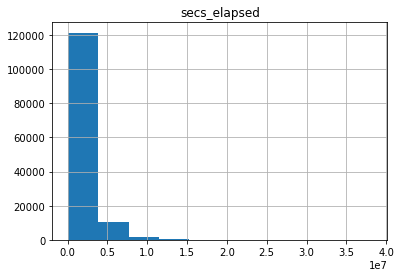

In [215]:
sessions1.groupby(by='user_id').aggregate(sum).hist()

In [216]:
p = pd.read_csv("train_users_2.csv")

In [217]:
joined = p.join(pd.DataFrame(num_unique_devices_per_user).reset_index().rename(columns={"user_id": "id", "device_type": "num_devices"}), how='left', on="id", lsuffix='', rsuffix='_r')

In [221]:
# merged = p.merge(devices_df, how='left', on='id')

In [222]:
# merged['num_devices'].isnull().value_counts()

In [223]:
newer_users = p[p['date_account_created'] > '2014-01-01']

In [ ]:
# merged = newer_users.merge(devices_df, how='left', on='id')

In [ ]:
# merged

In [224]:
numbers = merged['num_devices'].isnull().value_counts()
print("{0:.2f}% of users have no device history".format(numbers[True] / numbers.sum() * 100))


3.46% of users have no device history


## Potential features to generate from sessions data

- Number of times user has performed each action_type (One-hot encoding)
- Total secs_elapsed across all interactions
- Count of unique device_types used
- Binary features for top 10 action_details (e.g. has user performed view_search_results?)


### Number of times user has performed each action_type

In [225]:
action_type_counts = sessions.pivot_table(index='user_id', columns=['action_type'], aggfunc='size', fill_value=0)
action_type_counts = action_type_counts.rename(columns={"user_id": "id"})

### Total secs_elapsed across all interactions

In [226]:
total_seconds_elapsed = sessions.groupby(by='user_id')['secs_elapsed'].sum().fillna(0)
total_seconds_elapsed = total_seconds_elapsed.rename(columns={"user_id": "id"})

### Count of unique device_types

In [227]:
unique_devices_per_user = sessions.groupby(by='user_id')['device_type'].unique()
num_unique_devices_per_user = unique_devices_per_user.apply(lambda x: len(x))
devices_df = pd.DataFrame(num_unique_devices_per_user).reset_index().rename(columns={"user_id": "id", "device_type": "num_devices"})

### Counts for top 10 action values

In [228]:
top_10_actions = list(sessions['action'].value_counts()[:10].index)

In [230]:
subset_of_sessions = sessions[sessions['action'].isin(top_10_actions)]

In [231]:
dummified_top_10_actions = pd.get_dummies(subset_of_sessions, columns=['action'])

In [232]:
count_top_10_actions = dummified_top_10_actions.drop(['action_type', 'action_detail', 'device_type', 'secs_elapsed'], axis=1).groupby(by='user_id').sum()

In [257]:
output = count_top_10_actions.reset_index().rename(columns={"user_id":"id"}).merge(devices_df, how='left', on='id')

In [258]:
total_seconds_elapsed = pd.DataFrame(total_seconds_elapsed)
total_seconds_elapsed = total_seconds_elapsed.reset_index().rename(columns={"user_id":"id", 0:"total_seconds_elapsed"})

In [259]:
output = output.merge(total_seconds_elapsed, how="left", on="id")

In [260]:
output.head()

,id,action_ajax_refresh_subtotal,action_index,action_personalize,action_reviews,action_search,action_search_results,action_show,action_similar_listings,action_social_connections,action_update,num_devices,level_0,index,total_seconds_elapsed
0,00023iyk9l,2.0,4.0,4.0,0.0,0.0,1.0,9.0,3.0,0.0,0.0,2,0,0,867896.0
1,0010k6l0om,8.0,5.0,8.0,0.0,0.0,8.0,20.0,0.0,0.0,0.0,1,1,1,586543.0
2,001wyh0pz8,0.0,2.0,0.0,0.0,66.0,0.0,6.0,0.0,2.0,1.0,1,2,2,282965.0
3,0028jgx1x1,0.0,0.0,0.0,5.0,9.0,0.0,15.0,0.0,0.0,0.0,2,3,3,297010.0
4,002qnbzfs5,0.0,115.0,0.0,13.0,125.0,0.0,232.0,0.0,72.0,13.0,2,4,4,6487080.0


In [261]:
# /total_seconds_elapsed
# /count_top_10_actions
# /devices_df
# action_type_counts

In [263]:
action_type_counts = action_type_counts.reset_index().rename(columns={"user_id":"id"})
output = output.merge(action_type_counts, how='left', on='id')


In [271]:
output = output.drop(['level_0', 'index'], axis=1)

In [276]:
output = newer_users.merge(output, how='left', on="id")

In [282]:
best_users = output.dropna(how='any')
len(best_users)


20130

In [283]:
best_users.to_csv("best_user_records.csv")